In [20]:
# import PickScore model
from transformers import AutoProcessor, AutoModel
from PIL import Image
import torch

# load model
device = "cpu"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"

processor = AutoProcessor.from_pretrained(processor_name_or_path)
model1 = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)


def calc_probs(prompt, images):
    # preprocess
    image_inputs = processor(
        images=images,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)

    text_inputs = processor(
        text=prompt,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        # embed
        image_embs = model1.get_image_features(**image_inputs)
        image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)

        text_embs = model1.get_text_features(**text_inputs)
        text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)

        # score
        scores = model1.logit_scale.exp() * (text_embs @ image_embs.T)[0]

        # get probabilities if you have multiple images to choose from
        probs = torch.softmax(scores, dim=-1)

    return probs.cpu().tolist()
    

HPC(v1)
requirement：install clip following：https://github.com/openai/CLIP
download the hpc.pt checkpoint file from their repo...


In [2]:
# # import HPC classifier
# import clip

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model2, preprocess = clip.load("ViT-L/14", device=device)
# params = torch.load("path/to/hpc.pth")["state_dict"]
# model2.load_state_dict(params)

# image1 = preprocess(Image.open("image1.png")).unsqueeze(0).to(device)
# image2 = preprocess(Image.open("image2.png")).unsqueeze(0).to(device)
# images = torch.cat([image1, image2], dim=0)
# text = clip.tokenize(["your prompt here"]).to(device)

# with torch.no_grad():
#     image_features = model2.encode_image(images)
#     text_features = model2.encode_text(text)

#     image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#     text_features = text_features / text_features.norm(dim=-1, keepdim=True)

#     hps = image_features @ text_features.T

100%|███████████████████████████████████████| 890M/890M [09:54<00:00, 1.57MiB/s]


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/hpc.pth'

HPC v2:
 need to pip install hpsv2

In [4]:
import hpsv2

pip install image-reward first

In [5]:
# import ImageReward
# pip install image-reward
import ImageReward as RM

model = RM.load("ImageReward-v1.0")

ImageReward.pt: 100%|██████████| 1.79G/1.79G [01:24<00:00, 21.2MB/s]


load checkpoint from /Users/janewu/.cache/ImageReward/ImageReward.pt


med_config.json: 100%|██████████| 485/485 [00:00<00:00, 161kB/s]
tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 14.1kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 2.27MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 9.26MB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 566kB/s]


checkpoint loaded


In [34]:
import webdataset as wds
from PIL import Image
import io
import matplotlib.pyplot as plt
import os
import json

from warnings import filterwarnings

import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
from torchvision import datasets, transforms
import tqdm

from os.path import join
from datasets import load_dataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import json


from PIL import Image, ImageFile



# if you changed the MLP architecture during training, change it also here:
class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol="emb", ycol="avg_rating"):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            # nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            # nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            # nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            # nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


def normalized(a, axis=-1, order=2):
    import numpy as np  # pylint: disable=import-outside-toplevel

    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)


model3 = MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14

s = torch.load(
    "sac+logos+ava1-l14-linearMSE.pth", map_location="cpu"
)  # load the model you trained previously or the model available in this repo


device = "cuda" if torch.cuda.is_available() else "cpu"
model3.load_state_dict(s)

model3.to(device)
model3.eval()

model4, preprocess = clip.load("ViT-L/14", device=device)  # RN50x64


In [43]:
def rankScore(scores):
    sorted_indices = sorted(enumerate(scores), key=lambda x: x[1])

    # Create a ranking based on the sorted indices
    ranking = [0] * len(scores)
    for rank, (index, _) in enumerate(sorted_indices, start=1):
        ranking[index] = rank

    print("rankScore: ", ranking)


def hpc(prompt, images):
    result = hpsv2.score(images, prompt)
    print("hpc: ", result)
    rankScore(result)
    return result


def usePickScore(prompt, images):
    pil_images = [Image.open(img) for img in images]

    result = calc_probs(prompt, pil_images)

    print("pickScore", result)
    rankScore(result)
    return result


def imageReward(prompt, images):
    rewards = model.score(prompt, images)
    print("imageReward: ", rewards)
    rankScore(rewards)
    return rewards


def laion(images):
    scores = []
    for img in images:
        pil_image = Image.open(img)

        image = preprocess(pil_image).unsqueeze(0).to("cpu")

        with torch.no_grad():
            image_features = model4.encode_image(image)

        im_emb_arr = normalized(image_features.cpu().detach().numpy())

        prediction = model3(
            torch.from_numpy(im_emb_arr).to("cpu").type(torch.FloatTensor)
        )
        scores.append(prediction.item())
    print("Laion", scores)
    rankScore(scores)
    return scores

In [13]:
import pandas as pd

# Specify the path to your JSON file
json_file_path = "./img/test_1/test_1.json"

# Read the JSON file into a pandas DataFrame
df = pd.read_json(json_file_path)

# Sort the DataFrame by the "prompt" column
df = df.sort_values(by="prompt")

# Group by the "prompt" column and aggregate values into lists
grouped_df = df.groupby("prompt").agg(lambda x: x.tolist()).reset_index()

# Display the reorganized DataFrame
grouped_df.head()

prompt  \
0   promotional vogue studio portrait photo of Al...   
1  !13 hungry cannibals making a rich salad aroun...   
2  1970s action figure of Kanye West, product pho...   
3  3 d close - up minimalist coherent symmetrical...   
4  3 d fractal, octane render, unreal engine, int...   

                                          image_path  \
0  [images/test/test_1/1603b5b4-bb37-444e-ba32-42...   
1  [images/test/test_1/82826e22-3a43-466b-b921-5b...   
2  [images/test/test_1/5055d048-e37d-4790-9396-5f...   
3  [images/test/test_1/017fe6aa-cbd1-4828-b284-d0...   
4  [images/test/test_1/bb17a043-0510-438a-88b0-8c...   

                                           prompt_id  \
0  [008772-0049, 008772-0049, 008772-0049, 008772...   
1  [007135-0060, 007135-0060, 007135-0060, 007135...   
2  [007123-0054, 007123-0054, 007123-0054, 007123...   
3  [009633-0168, 009633-0168, 009633-0168, 009633...   
4  [008293-0194, 008293-0194, 008293-0194, 008293...   

                                      classification  \
0   [People, People, People, People, People, People]   
1  [People, People, People, People, People, Peopl...   
2  [Artifacts, Artifacts, Artifacts, Artifacts, A...   
3                           [Arts, Arts, Arts, Arts]   
4                           [Arts, Arts, Arts, Arts]   

      image_amount_in_total                      rank  \
0        [6, 6, 6, 6, 6, 6]        [2, 4, 4, 5, 3, 1]   
1  [8, 8, 8, 8, 8, 8, 8, 8]  [3, 3, 2, 2, 1, 1, 4, 4]   
2  [8, 8, 8, 8, 8, 8, 8, 8]  [4, 4, 3, 2, 2, 1, 5, 1]   
3              [4, 4, 4, 4]              [1, 4, 3, 2]   
4              [4, 4, 4, 4]              [5, 5, 3, 2]   

             overall_rating image_text_alignment_rating  \
0        [5, 4, 4, 4, 5, 5]          [6, 5, 5, 5, 6, 6]   
1  [4, 4, 4, 4, 4, 4, 3, 3]    [4, 4, 4, 4, 4, 4, 4, 4]   
2  [5, 5, 5, 5, 5, 5, 4, 6]    [5, 5, 5, 5, 5, 5, 4, 6]   
3              [6, 4, 4, 5]                [6, 4, 4, 5]   
4              [1, 1, 6, 6]                [1, 1, 5, 6]   

            fidelity_rating  
0        [5, 4, 4, 4, 4, 4]  
1  [4, 4, 3, 3, 5, 4, 2, 2]  
2  [6, 5, 6, 6, 5, 6, 5, 6]  
3              [6, 6, 6, 6]  
4              [1, 1, 6, 6]

In [24]:
print(len(grouped_df))

249


prompt:  1970s action figure of Kanye West, product photography, plastic toy, white background, isolated background, studio lighting
score: [5, 5, 5, 5, 5, 5, 4, 6]
rank: [4, 4, 3, 2, 2, 1, 5, 1]


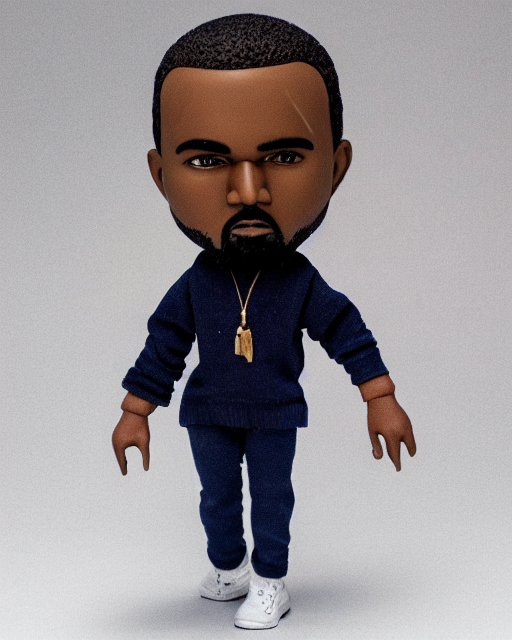

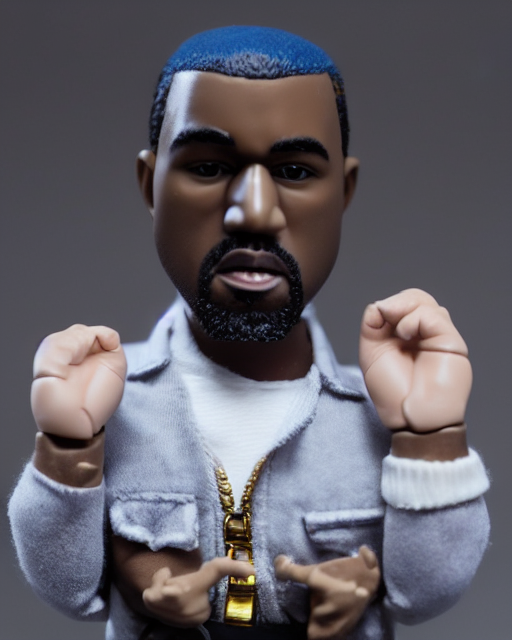

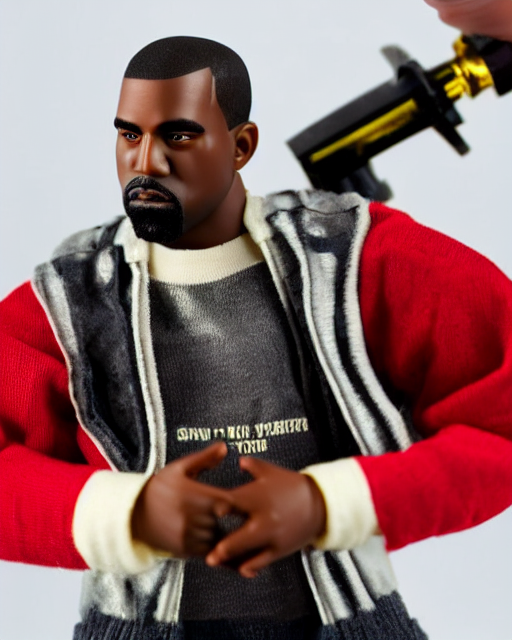

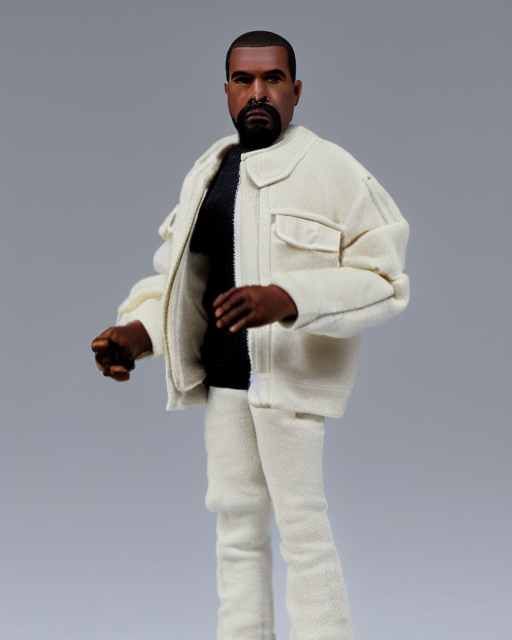

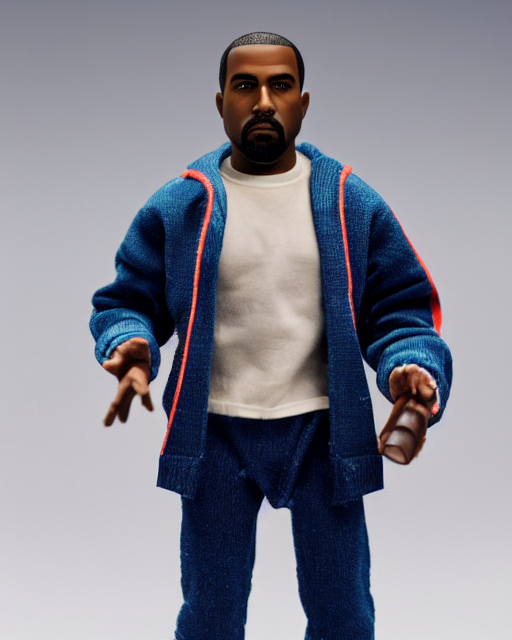

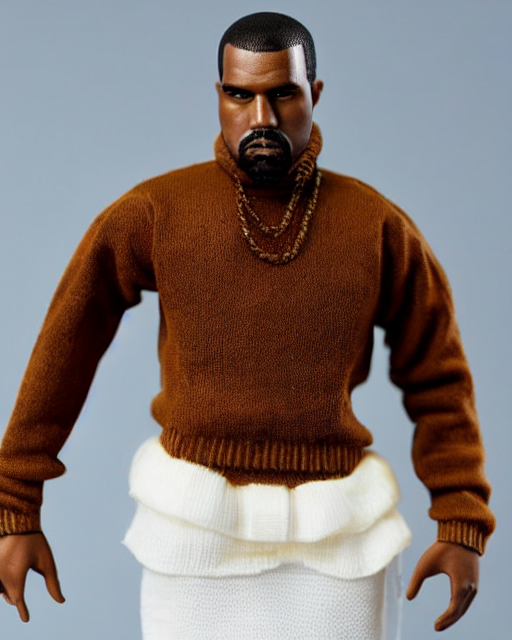

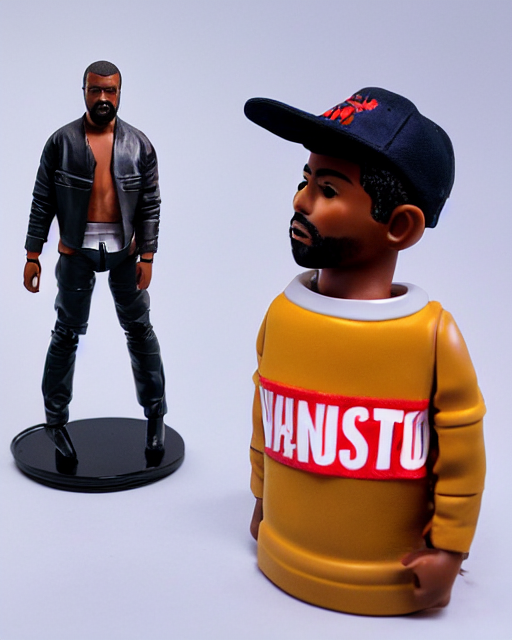

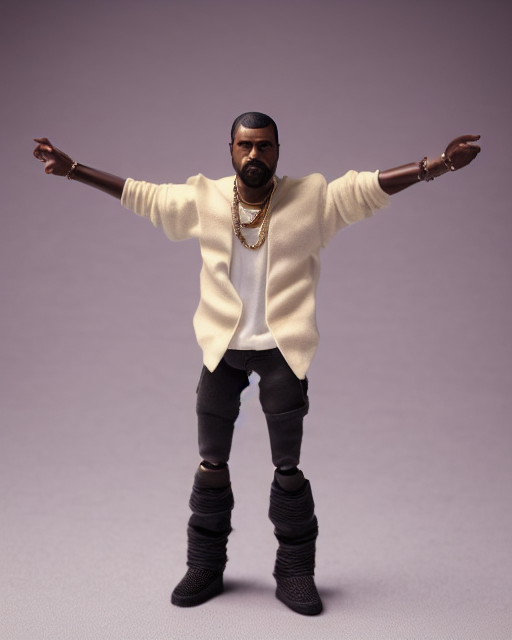

In [36]:
from PIL import Image
from IPython.display import display

seed = 2

img = grouped_df["image_path"][seed]
rank = grouped_df["rank"][seed]
prompt = grouped_df["prompt"][seed]
rating = grouped_df["overall_rating"][seed]

print("prompt: ", prompt)
print("score:", rating)
print("rank:", rank)

for path in img:
    # Open the WebP image using PIL
    pil_image = Image.open(path)

    # Display the WebP image
    display(pil_image)


In [44]:
# group
_ = imageReward(prompt, img)
# group
_ = hpc(prompt, img)
# group
_ = usePickScore(prompt, img)
# run one by one, no prompt
_ = laion(img)

imageReward:  [1.1501195430755615, 0.320046067237854, 0.7998093962669373, 0.3398561179637909, 1.2056488990783691, 0.8165105581283569, 0.7558878660202026, 0.7946299910545349]
rankScore:  [7, 1, 5, 2, 8, 6, 3, 4]
hpc:  [0.2599445, 0.26548314, 0.26427317, 0.25496194, 0.2670031, 0.265956, 0.25313044, 0.26252437]
rankScore:  [3, 6, 5, 2, 8, 7, 1, 4]
pickScore [0.131803497672081, 0.13425549864768982, 0.14689362049102783, 0.07297897338867188, 0.14698611199855804, 0.0575215183198452, 0.04309345781803131, 0.26646730303764343]
rankScore:  [4, 5, 6, 3, 7, 2, 1, 8]
Laion [5.094078540802002, 4.989876747131348, 4.94529390335083, 5.112273693084717, 4.899852752685547, 4.903618812561035, 4.636541843414307, 4.773118495941162]
rankScore:  [7, 6, 5, 8, 3, 4, 1, 2]
